Potting Data Analysis - New Routine
===================================

This notebook will contain analysis of the data saved in logfiles by the new module potting routine.

First, one must prepare the datafiles.
  1. Log into the t3
  2. execute the following command to create an archive of all potting data 
      ```sh
      zip -uj Potting_Logs.zip /home/dominguez/cfangmeier/elog_git/logbooks/SiLab_Logbook/*/*_Config-*-*-*.zip
      ```
  3. Copy Potting_Logs.zip into the same directory as this notebook
  4. Run the script to convert the logfiles to JSON
     ```sh
     ./PottingLog2JSON.py Potting_Logs.zip
     ```

Alternatively, You can just run the pre-prepared script to automate these steps. Note that you must give the script your t3 username as the first argument so it can execute the scp and ssh commands appropriately.

After running the above, the resulting json can be read in and processed.

In [1]:
%matplotlib notebook
from IPython.display import Markdown, display_markdown
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from itertools import cycle
import json
import pprint

plt.style.use('fivethirtyeight')
plt_cols = cycle([col['color'] for col in plt.rcParams['axes.prop_cycle']._left])

In [2]:
dec = json.JSONDecoder()
with open('Potting_Logs.json','r') as f:
    modules = dec.decode(f.read())
pprint.pprint(modules[1])

{'BBM_center': ['280.821903', '245.191623', '62.367703'],
 'BBM_fids': {'fid_BL': {'fid_pos': ['271.736642', '278.625131', '62.363950'],
                         'img_crd': ['0.455586', '0.688575', '0.000000'],
                         'img_pos': ['271.785276', '278.469745', '62.363950'],
                         'name': 'fid_BL',
                         'source': 'Pattern Recognition'},
              'fid_BR': {'fid_pos': ['289.992763', '278.606028', '62.353626'],
                         'img_crd': ['0.409605', '0.654538', '0.000000'],
                         'img_pos': ['290.091746', '278.478689', '62.353626'],
                         'name': 'fid_BR',
                         'source': 'Pattern Recognition'},
              'fid_TL': {'fid_pos': ['271.651648', '211.778332', '62.335859'],
                         'img_crd': ['0.348015', '0.758023', '0.000000'],
                         'img_pos': ['271.818072', '211.565721', '62.335859'],
                         'name': 'fid_TL',

In [3]:
ss = ['|ID | Operator | Date | Time (min) | Chuck | Slot | Offset ($\mu$m) | Rotation (deg) |',
      '|---|----------|------|-----------:|------:|-----:|----------------:|---------------:|']
for module in modules:
    id_ = module.get('id','N/A')
    operator = module.get('operator_name','N/A')
    try:
        dt = module['date_potted']
        date = "{:02d}/{:02d}/{:04d}".format(dt['month'], dt['day'], dt['year'])
    except Exception as e:
        date = "N/A"
    time = module.get('time',0)
    chuck = int(module.get('chuck','N/A'))
    slot = int(module.get('slot', 'N/A'))
    bbm_center = [float(x) for x in module['BBM_center']][:2]
    hdi_center = [float(x) for x in module['HDI_center']][:2]
    offset = sum((x-y)**2 for x,y in zip(bbm_center, hdi_center))*1000
    rotation = abs(float(module['BBM_rotatn']) - float(module['HDI_rotatn']))
    s = "|{id}|{op}|{date}|{time}|{chuck:02d}|{slot:02d}|{offset:.03f}|{rotation:.03f}"
    s = s.format(id=id_, op=operator, date=date, time=time, chuck=chuck, slot=slot, offset=offset, rotation=rotation)
    ss.append(s)
m = Markdown('\n'.join(ss))
display_markdown(m)

|ID | Operator | Date | Time (min) | Chuck | Slot | Offset ($\mu$m) | Rotation (deg) |
|---|----------|------|-----------:|------:|-----:|----------------:|---------------:|
|M-K-2-01|Savanna|04/01/2016|31|02|01|0.284|0.152
|M-K-2-38|Kevin|04/04/2016|33|02|02|0.411|0.333
|M-L-1-07|Kevin|04/04/2016|30|02|04|0.296|0.302
|M-L-1-08|Kevin|04/04/2016|29|02|01|0.664|0.416
|M-L-2-18|Kevin|04/04/2016|31|02|02|0.822|0.262
|M-L-1-23|Levi|04/05/2016|35|02|03|0.817|0.134
|M-L-1-43|Levi|04/05/2016|31|02|04|0.852|0.193

<IPython.core.display.Javascript object>


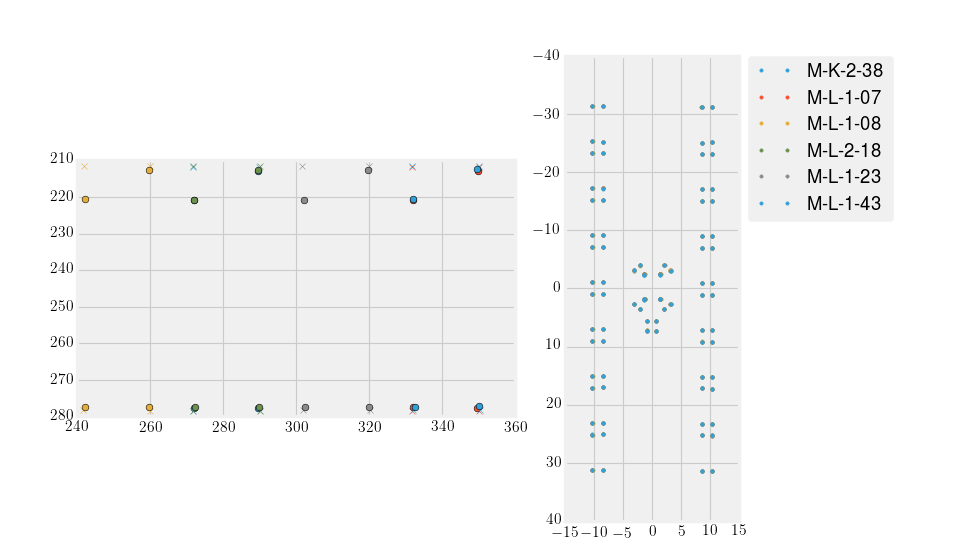

In [4]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1,.7]) 
ax_fid = fig.add_subplot(gs[0],  adjustable='box', aspect=1)
ax_pot = fig.add_subplot(gs[1],  adjustable='box', aspect=1)
for color, module in zip(plt_cols,modules[1:]):
    pts_local = []
    for val in module['pot_lines'].values():
        pts_local.append(val['local']['start'])
        pts_local.append(val['local']['end'])

    xs,ys,zs = zip(*pts_local)
    ax_pot.plot(xs,ys, '.', label=module['id'], color=color)
    pts_local.clear()
    for val in module['BBM_fids'].values():
        pts_local.append(val['fid_pos'])
    xs,ys,zs = zip(*pts_local)
    ax_fid.plot(xs,ys, 'x', label=module['id'], color=color)
    pts_local.clear()
    for val in module['HDI_fids'].values():
        pts_local.append(val['fid_pos'])
    xs,ys,zs = zip(*pts_local)
    ax_fid.plot(xs,ys, 'o', label=module['id'], color=color)
ax_fid.set_ylim((280,210))
ax_pot.set_ylim((40,-40))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()